In [1]:
import torch
import torch.nn as nn
import pandas as pd
from project.dataset import VALDODataset
from torch.utils.data import DataLoader
from project.preprocessing import NiftiToTensorTransform, NEWNiftiToTensorTransform
from project.utils import collatev2
from project.utils import compute_statistics
from project.evaluation import isa_vit_metric, Tracker

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.21 (you have 1.4.7). Upgrade using: pip install --upgrade albumentations


In [2]:
vit_tk = Tracker()

### Monitoring and CUDA Setup


In [3]:
import logging
from datetime import datetime as dtt
import os

path = 'logs'
os.makedirs(path, exist_ok=True)
os.makedirs('history', exist_ok=True)
rn = dtt.now()
dte = rn.strftime('%b_%d_%Y_%H%M%S')

logger = logging.getLogger('kess')
fh = logging.FileHandler(f'logs/rpn_vit_{dte}.log')
formatter = logging.Formatter(
    '%(asctime)s - %(levelname)s - %(message)s'
)

logger.setLevel(logging.DEBUG)
fh.setLevel(logging.DEBUG)
fh.setFormatter(formatter)

logger.addHandler(fh)

dte

'Nov_25_2024_054620'

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [5]:
vit_tk.date = rn
vit_tk.logfile = f'rpn_vit_{dte}.log'
vit_tk.device = device

### Config for RPN and ViT Fitter


In [6]:
from project.model import ISAVIT, Feeder

In [7]:
image_size = 300
num_patches = 16
patch_size = image_size/num_patches**.5
assert patch_size == int(patch_size), 'image size must be divisible by patch size'
patch_size = int(patch_size)

In [8]:
vit_config = {
    'model': ISAVIT(
        d_model=512,
        patch_size=patch_size,
        dim_ff=1600,
        global_context=True,
    ).to(device),
    'optimizer': torch.optim.Adam,
    'device': device,
    'epochs': 20,
    'loss': nn.BCEWithLogitsLoss(),
    'lr': 0.0001
}

C:\Program Files\Python310\lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [9]:
vit_tk.model = 'ViT'
vit_tk.model_hyperparams = vit_config['model'].config
vit_tk.optimizer = f"{vit_config['optimizer']}"
vit_tk.epochs = vit_config['epochs']
vit_tk.loss = f"{vit_config['loss']}"
vit_tk.lr = vit_config['lr']

### Dataset Loading


In [10]:
data = pd.read_csv('targets.csv')
data.shape

(7986, 9)

In [11]:
data = data.query('has_microbleed_slice == 1').reset_index(drop=True)
data

,mri,masks,stripped,target,has_microbleed_case,has_microbleed_slice,cohort,max_value,slices
0,C:\Users\araza\Documents\1\gits\thesis_project...,C:\Users\araza\Documents\1\gits\thesis_project...,C:\Users\araza\Documents\1\gits\thesis_project...,8,1,1,1,928.405273,35
1,C:\Users\araza\Documents\1\gits\thesis_project...,C:\Users\araza\Documents\1\gits\thesis_project...,C:\Users\araza\Documents\1\gits\thesis_project...,9,1,1,1,928.405273,35
2,C:\Users\araza\Documents\1\gits\thesis_project...,C:\Users\araza\Documents\1\gits\thesis_project...,C:\Users\araza\Documents\1\gits\thesis_project...,11,1,1,1,928.405273,35
3,C:\Users\araza\Documents\1\gits\thesis_project...,C:\Users\araza\Documents\1\gits\thesis_project...,C:\Users\araza\Documents\1\gits\thesis_project...,12,1,1,1,928.405273,35
4,C:\Users\araza\Documents\1\gits\thesis_project...,C:\Users\araza\Documents\1\gits\thesis_project...,C:\Users\araza\Documents\1\gits\thesis_project...,15,1,1,1,928.405273,35
...,...,...,...,...,...,...,...,...,...
359,C:\Users\araza\Documents\1\gits\thesis_project...,C:\Users\araza\Documents\1\gits\thesis_project...,C:\Users\araza\Documents\1\gits\thesis_project...,25,1,1,3,241.000000,36
360,C:\Users\araza\Documents\1\gits\thesis_project...,C:\Users\araza\Documents\1\gits\thesis_project...,C:\Users\araza\Documents\1\gits\thesis_project...,26,1,1,3,241.000000,36
361,C:\Users\araza\Documents\1\gits\thesis_project...,C:\Users\araza\Documents\1\gits\thesis_project...,C:\Users\araza\Documents\1\gits\thesis_project...,24,1,1,3,448.000000,39
362,C:\Users\araza\Documents\1\gits\thesis_project...,C:\Users\araza\Documents\1\gits\thesis_project...,C:\Users\araza\Documents\1\gits\thesis_project...,25,1,1,3,448.000000,39


In [12]:
vit_tk.only_cmb_slices = True

In [13]:
def make_feedset(
        data,
        patch_size,
        target_shape=(300, 300),
        rpn_mode=True,
        logger=None
    ):
    s = f'Creating feedset\n'
    paths = data.stripped.unique().tolist()
    s += f'Total Unique MRI Samples in data_train: {len(paths)}\n'
    
    global_min, global_max = compute_statistics(paths)
    s += f'GLOBAL MIN & MAX {global_min, global_max}\n'
    global_min, global_max = compute_statistics(paths)
    
    feedset_transform = NEWNiftiToTensorTransform(
        target_shape=target_shape,
        rpn_mode=rpn_mode,
        normalization=(global_min, global_max),
        patch_size=patch_size
    )
    feedset = VALDODataset(
    cases=data.stripped,
    masks=data.masks,
    target=data.target,
    transform=feedset_transform
    )
    print(s)
    return feedset

In [14]:
feedset = make_feedset(
    data=data,
    patch_size=patch_size,
    rpn_mode=True,
    target_shape=(300, 300)
)

Creating feedset
Total Unique MRI Samples in data_train: 50
GLOBAL MIN & MAX (0.0, 87519.8515625)



### Preprocessing and Train-Test Split Function


In [15]:
from sklearn.model_selection import train_test_split

def make_loaders(data,
                 cohort,
                 test_size=0.2,
                 random_state=12,
                 target_shape=(300, 300),
                 rpn_mode=True,
                 logger=None,
                ):
    
    if cohort == 1:
        vit_tk.cohort1 = True
    if cohort == 2:
        vit_tk.cohort2 = True
    if cohort == 3:
        vit_tk.cohort3 = True

    vit_tk.test_size = test_size
    vit_tk.target_shape = target_shape
    data = data[data.cohort == cohort]
    
    s = f'Creating loaders for Cohort {cohort}\n'

    data_train, data_test = train_test_split(
        data,
        test_size=test_size,
        random_state=random_state
    )

    s += f'TRAIN & TEST: {data_train.shape, data_test.shape}\n'

    paths = data_train.stripped.unique().tolist()
    s += f'Total Unique MRI Samples in data_train: {len(paths)}\n'
    
    global_min, global_max = compute_statistics(paths)
    s += f'GLOBAL MIN & MAX {global_min, global_max}\n'

    transform = NiftiToTensorTransform(
        target_shape=target_shape,
        rpn_mode=rpn_mode,
        normalization=(global_min, global_max)
    )

    train_set = VALDODataset(
        cases=data_train.stripped.tolist(),
        masks=data_train.masks.tolist(),
        target=data_train.target.tolist(),
        transform=transform
    )
    val_set = VALDODataset(
        cases=data_test.stripped.tolist(),
        masks=data_test.masks.tolist(),
        target=data_test.target.tolist(),
        transform=transform
    )

    if logger != None:
        logger.info(s)
    else:
        print(s)
    
    return train_set, val_set

In [16]:
from project import Fitter, AnchorFeeder
# from project.preprocessing import get_transform

In [17]:
feeder = AnchorFeeder(patch_size)

### ViT Fitter


In [18]:
from project import Fitter

class ViTFitter(Fitter):
    
    def fit(self, train_loader, val_loader):
        train_history = []
        val_history = []
        train_metric_history = []
        val_metric_history = []
        for epoch in range(self.epochs):
            self.log(f'EPOCH {epoch} ==============================')
            train_loss, train_metric = self.train_one_epoch(train_loader)
            val_loss, val_metric = self.validation(val_loader)
            train_history.append(train_loss)
            val_history.append(val_loss)
            train_metric_history.append(train_metric)
            val_metric_history.append(val_metric)
        return train_history, val_history, train_metric_history, val_metric_history

    def train_one_epoch(self, train_loader):
        self.model.train()
        loss_history = []
        evaluation_metric = {
            'dice_score': [], 
            'precision_score': [], 
            'recall_score': [], 
            'f1_score': [],
            'fpr': []
        }
        counter = 0
        for batch in train_loader:
            Y = []
            T = []
            for slices, masks, target, case in batch:
                slices = slices.squeeze(1).float().to(self.device)
                masks = masks.float().to(self.device)

                # regions = feedset.locate_case_by_mri(case)
                # bboxes = regions[1].view(regions[1].shape[0], -1)
                # bbox = bboxes[target].int().tolist()
                gtruths = feedset.locate_case_by_mri(case)[1]
                classes = gtruths[target].squeeze().nonzero().squeeze()
                if classes.nelement() == 1:
                    random_patch_with_cmb = classes.tolist()
                else:
                    random_patch_with_cmb = classes[torch.randint(classes.nelement(), (1,))].squeeze().tolist()
                
                # x = feeder(slices, bbox, 32)
                # t = feeder(masks, bbox, 32)
                cmri = []
                for i in range(slices.shape[0]):
                    slc = feeder(slices[i].unsqueeze(0).float(), random_patch_with_cmb).unsqueeze(0)
                    cmri.append(slc)
                x = torch.stack(cmri)

                cmask = []
                for i in range(masks.shape[0]):
                    slc = feeder(masks[i].unsqueeze(0).float(), random_patch_with_cmb).unsqueeze(0)
                    cmask.append(slc)
                t = torch.stack(cmask)

                x = x.flatten(2).float().to(self.device)
                t = t.flatten(2).float().to(self.device)
                # self.log(f'XT SHAPES: {x.shape}, {t.shape}')
                
                y = self.model(x, target)
                
                # print('Prediction:', (y.sigmoid() >= 0.5).int().unique())
                # print('Truth:', (t[target] >= 0).int().unique())

                dice_score, precision_score, recall_score, f1_score, fpr = isa_vit_metric((y.sigmoid().squeeze().detach().cpu().numpy() >= 0.5), t[target].squeeze().detach().cpu().numpy())

                evaluation_metric['dice_score'].append(dice_score)
                evaluation_metric['precision_score'].append(precision_score)
                evaluation_metric['recall_score'].append(recall_score)
                evaluation_metric['f1_score'].append(f1_score)
                evaluation_metric['fpr'].append(fpr)
                # self.log(f'EVAL METS: {dice_score, precision_score, recall_score, f1_score, fpr}')

                Y.append(y)
                T.append(t[target])
            
            losses = self.loss(torch.stack(Y), torch.stack(T))
            self.optimizer.zero_grad()
            losses.backward()
            self.optimizer.step()
            counter += 1
            self.log(f'Batch:\t{counter}/{len(train_loader)}')
            self.log(f'Batch samples:\t{len(batch)}')
            self.log(f'Current error:\t{losses}\n')
            
            loss_history.append(losses.detach().cpu().numpy())
        
        self.log(f'\nTraining Evaluation Metric:')
        self.log(f"Avg Dice: {sum(evaluation_metric['dice_score']) / len(evaluation_metric['dice_score'])}")
        self.log(f"Avg Precision: {sum(evaluation_metric['precision_score']) / len(evaluation_metric['precision_score'])}")
        self.log(f"Avg Recall: {sum(evaluation_metric['recall_score']) / len(evaluation_metric['recall_score'])}")
        self.log(f"Avg F1: {sum(evaluation_metric['f1_score']) / len(evaluation_metric['f1_score'])}")
        self.log(f"Avg FPR: {sum(evaluation_metric['fpr']) / len(evaluation_metric['fpr'])}\n")
        return loss_history, evaluation_metric
    
    def validation(self, val_loader):
        self.model.eval()
        loss_history = []
        evaluation_metric = {
            'dice_score': [], 
            'precision_score': [], 
            'recall_score': [], 
            'f1_score': [],
            'fpr': []
        }
        with torch.inference_mode():
            for batch in val_loader:
                Y = []
                T = []
                for slices, masks, target, case in batch:
                    slices = slices.squeeze(1).float().to(self.device)
                    masks = masks.float().to(self.device)
                    # regions = feedset.locate_case_by_mri(case)
                    # bboxes = regions[1].view(regions[1].shape[0], -1)
                    # bbox = bboxes[target].int().tolist()
                    gtruths = feedset.locate_case_by_mri(case)[1]
                    classes = gtruths[target].squeeze().nonzero().squeeze()
                    if classes.nelement() == 1:
                        random_patch_with_cmb = classes.tolist()
                    else:
                        random_patch_with_cmb = classes[torch.randint(classes.nelement(), (1,))].squeeze().tolist()
                    
                    # x = feeder(slices, bbox, 32)
                    # t = feeder(masks, bbox, 32)
                    cmri = []
                    for i in range(slices.shape[0]):
                        slc = feeder(slices[i].unsqueeze(0).float(), random_patch_with_cmb).unsqueeze(0)
                        cmri.append(slc)
                    x = torch.stack(cmri)
    
                    cmask = []
                    for i in range(masks.shape[0]):
                        slc = feeder(masks[i].unsqueeze(0).float(), random_patch_with_cmb).unsqueeze(0)
                        cmask.append(slc)
                    t = torch.stack(cmask)
                
                    x = x.flatten(2).float().to(self.device)
                    t = t.flatten(2).float().to(self.device)
                    y = self.model(x, target)

                    dice_score, precision_score, recall_score, f1_score, fpr = isa_vit_metric((y.sigmoid().squeeze().detach().cpu().numpy() >= 0.5), t[target].squeeze().detach().cpu().numpy())
                    evaluation_metric['dice_score'].append(dice_score)
                    evaluation_metric['precision_score'].append(precision_score)
                    evaluation_metric['recall_score'].append(recall_score)
                    evaluation_metric['f1_score'].append(f1_score)
                    evaluation_metric['fpr'].append(fpr)
                    Y.append(y)
                    T.append(t[target])
                
                losses = self.loss(torch.stack(Y), torch.stack(T))
                loss_history.append(losses.cpu().numpy())
        
        self.log(f'\nValidations Evaluation Metric:')
        self.log(f"Avg Dice: {sum(evaluation_metric['dice_score']) / len(evaluation_metric['dice_score'])}")
        self.log(f"Avg Precision: {sum(evaluation_metric['precision_score']) / len(evaluation_metric['precision_score'])}")
        self.log(f"Avg Recall: {sum(evaluation_metric['recall_score']) / len(evaluation_metric['recall_score'])}")
        self.log(f"Avg F1: {sum(evaluation_metric['f1_score']) / len(evaluation_metric['f1_score'])}")
        self.log(f"Avg FPR: {sum(evaluation_metric['fpr']) / len(evaluation_metric['fpr'])}\n")
        return loss_history, evaluation_metric

### Train-Test Split


In [19]:
vit_t1, vit_v1 = make_loaders(
    data=data,
    cohort=1,
    rpn_mode=False
)

vit_t3, vit_v3 = make_loaders(
    data=data,
    cohort=3,
    rpn_mode=False
)

Creating loaders for Cohort 1
TRAIN & TEST: ((36, 9), (9, 9))
Total Unique MRI Samples in data_train: 8
GLOBAL MIN & MAX (0.0, 1417.92822265625)

Creating loaders for Cohort 3
TRAIN & TEST: ((37, 9), (10, 9))
Total Unique MRI Samples in data_train: 26
GLOBAL MIN & MAX (0.0, 573.0)



In [20]:
from torch.utils.data import ConcatDataset

vit_train_set = ConcatDataset([vit_t1, vit_t3])
vit_test_set = ConcatDataset([vit_v1, vit_v3])

print(f'ViT Train Set Size: {vit_train_set}')
print(f'ViT Test Set Size: {vit_test_set}')

ViT Train Set Size: <torch.utils.data.dataset.ConcatDataset object at 0x000001EE83E8A770>
ViT Test Set Size: <torch.utils.data.dataset.ConcatDataset object at 0x000001EE83E8BEE0>


In [21]:
batchs = 15
vit_tk.batch_size = batchs

vit_test_dataloader = DataLoader(
    vit_test_set,
    shuffle=True,
    batch_size=batchs,
    collate_fn=collatev2
)

### K-Fold Cross Validation


In [22]:
from torch.utils.data import Subset
from sklearn.model_selection import KFold

In [23]:
kf = KFold(n_splits=5, shuffle=True, random_state=45)
kf

KFold(n_splits=5, random_state=45, shuffle=True)

In [24]:
from project.model import Feeder, GCRPN
from project.preprocessing import NiftiToTensorTransform, get_transform

In [25]:
vit_test_dice = []
vit_test_precision = []
vit_test_recall = []
vit_test_f1 = []
vit_test_fpr = []

In [26]:
rpn_fold_metrics = []
vit_fold_metrics = []


fold_dir = f'./fold/{dte}'
os.makedirs(fold_dir, exist_ok=True)

for i, (train_index, val_index) in enumerate(kf.split(vit_train_set)):
    print(f'Fold {i + 1}/{5}')

    os.makedirs(f'{fold_dir}/fold_{i+1}', exist_ok=True)

    # ViT
    
    vit_config['model'] = ISAVIT(**vit_tk.model_hyperparams).to(device)
    
    vit_fitter = ViTFitter(vit_config, logger=logger)
    
    train_subset = Subset(vit_train_set, train_index)
    val_subset = Subset(vit_train_set, val_index)

    vit_tk.batch_size = 15
    
    train_subset_dl = DataLoader(
        train_subset,
        shuffle=True,
        batch_size=vit_tk.batch_size,
        collate_fn=collatev2
    )
    
    val_subset_dl = DataLoader(
        val_subset,
        shuffle=True,
        batch_size=vit_tk.batch_size,
        collate_fn=collatev2
    )
    
    vit_thist, vit_vhist, vit_tmhist, vit_vmhist = vit_fitter.fit(train_subset_dl, val_subset_dl)
    
    vit_fold_metrics.append({
        'fold': i + 1,
        'training_history': vit_thist,
        'validation_history': vit_vhist,
        'training_metrics': vit_tmhist,
        'validation_metrics': vit_vmhist
    })
    
    vit_h, vit_mh = vit_fitter.validation(vit_test_dataloader)
    vit_valmets = pd.DataFrame(vit_mh)
    vit_mets = vit_valmets.mean()
    
    vit_test_dice.append(vit_mets.dice_score)
    vit_test_precision.append(vit_mets.precision_score)
    vit_test_recall.append(vit_mets.recall_score)
    vit_test_f1.append(vit_mets.f1_score)
    vit_test_fpr.append(vit_mets.fpr)
    
    torch.save(vit_fitter.model.state_dict(), f'{fold_dir}/fold_{i+1}/vit_fold{i+1}.pt')

    

Fold 1/5


C:\Program Files\Python310\lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
INFO:kess:EPOCH 0 ==============================
C:\Program Files\Python310\lib\site-packages\torch\nn\functional.py:5504: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)
INFO:kess:Batch:	1/3
INFO:kess:Batch samples:	20
INFO:kess:Current error:	0.7300809025764465

INFO:kess:Batch:	2/3
INFO:kess:Batch samples:	20
INFO:kess:Current error:	0.7171192169189453

INFO:kess:Batch:	3/3
INFO:kess:Batch samples:	18
INFO:kess:Curren

Fold 2/5


INFO:kess:Batch:	1/3
INFO:kess:Batch samples:	20
INFO:kess:Current error:	0.7347280979156494

INFO:kess:Batch:	2/3
INFO:kess:Batch samples:	20
INFO:kess:Current error:	0.7214674949645996

INFO:kess:Batch:	3/3
INFO:kess:Batch samples:	18
INFO:kess:Current error:	0.7092884182929993

INFO:kess:
Training Evaluation Metric:
INFO:kess:Avg Dice: 0.0039449354467189016
INFO:kess:Avg Precision: 0.0019964793336039034
INFO:kess:Avg Recall: 0.4442124550766813
INFO:kess:Avg F1: 0.0039449354467189016
INFO:kess:Avg FPR: 0.32762962320570677

INFO:kess:
Validations Evaluation Metric:
INFO:kess:Avg Dice: 0.0027991079640450832
INFO:kess:Avg Precision: 0.0014065783676758905
INFO:kess:Avg Recall: 0.34178571428571425
INFO:kess:Avg F1: 0.0027991079640450832
INFO:kess:Avg FPR: 0.30964144764839113

INFO:kess:EPOCH 1 ==============================
INFO:kess:Batch:	1/3
INFO:kess:Batch samples:	20
INFO:kess:Current error:	0.7002004384994507

INFO:kess:Batch:	2/3
INFO:kess:Batch samples:	20
INFO:kess:Current error:

Fold 3/5


INFO:kess:Batch:	1/3
INFO:kess:Batch samples:	20
INFO:kess:Current error:	0.7329423427581787

INFO:kess:Batch:	2/3
INFO:kess:Batch samples:	20
INFO:kess:Current error:	0.7201821804046631

INFO:kess:Batch:	3/3
INFO:kess:Batch samples:	18
INFO:kess:Current error:	0.7067439556121826

INFO:kess:
Training Evaluation Metric:
INFO:kess:Avg Dice: 0.0036020370519774026
INFO:kess:Avg Precision: 0.0018134811698265606
INFO:kess:Avg Recall: 0.4451630750217098
INFO:kess:Avg F1: 0.003602037051977402
INFO:kess:Avg FPR: 0.3253505117761004

INFO:kess:
Validations Evaluation Metric:
INFO:kess:Avg Dice: 0.002629951008725332
INFO:kess:Avg Precision: 0.0013205806627163516
INFO:kess:Avg Recall: 0.45012928248222367
INFO:kess:Avg F1: 0.002629951008725332
INFO:kess:Avg FPR: 0.307165630467533

INFO:kess:EPOCH 1 ==============================
INFO:kess:Batch:	1/3
INFO:kess:Batch samples:	20
INFO:kess:Current error:	0.6950387954711914

INFO:kess:Batch:	2/3
INFO:kess:Batch samples:	20
INFO:kess:Current error:	0.684

Fold 4/5


INFO:kess:Batch:	1/3
INFO:kess:Batch samples:	20
INFO:kess:Current error:	0.732123613357544

INFO:kess:Batch:	2/3
INFO:kess:Batch samples:	20
INFO:kess:Current error:	0.7208314538002014

INFO:kess:Batch:	3/3
INFO:kess:Batch samples:	19
INFO:kess:Current error:	0.7064792513847351

INFO:kess:
Training Evaluation Metric:
INFO:kess:Avg Dice: 0.003085402142459615
INFO:kess:Avg Precision: 0.0015514884123562782
INFO:kess:Avg Recall: 0.4750701000543519
INFO:kess:Avg F1: 0.003085402142459615
INFO:kess:Avg FPR: 0.3244696392840651

INFO:kess:
Validations Evaluation Metric:
INFO:kess:Avg Dice: 0.0028714205576126192
INFO:kess:Avg Precision: 0.0014429582228272042
INFO:kess:Avg Recall: 0.36355809867806765
INFO:kess:Avg F1: 0.0028714205576126192
INFO:kess:Avg FPR: 0.30908814697388565

INFO:kess:EPOCH 1 ==============================
INFO:kess:Batch:	1/3
INFO:kess:Batch samples:	20
INFO:kess:Current error:	0.6963403224945068

INFO:kess:Batch:	2/3
INFO:kess:Batch samples:	20
INFO:kess:Current error:	0.6

Fold 5/5


INFO:kess:Batch:	1/3
INFO:kess:Batch samples:	20
INFO:kess:Current error:	0.7314745783805847

INFO:kess:Batch:	2/3
INFO:kess:Batch samples:	20
INFO:kess:Current error:	0.7188907265663147

INFO:kess:Batch:	3/3
INFO:kess:Batch samples:	19
INFO:kess:Current error:	0.705860435962677

INFO:kess:
Training Evaluation Metric:
INFO:kess:Avg Dice: 0.003957178769680023
INFO:kess:Avg Precision: 0.0020009042776051498
INFO:kess:Avg Recall: 0.4749113560126164
INFO:kess:Avg F1: 0.003957178769680023
INFO:kess:Avg FPR: 0.3233553206386115

INFO:kess:
Validations Evaluation Metric:
INFO:kess:Avg Dice: 0.0031390366927853378
INFO:kess:Avg Precision: 0.0015801455968176316
INFO:kess:Avg Recall: 0.36370046451182353
INFO:kess:Avg F1: 0.003139036692785338
INFO:kess:Avg FPR: 0.3042841546724056

INFO:kess:EPOCH 1 ==============================
INFO:kess:Batch:	1/3
INFO:kess:Batch samples:	20
INFO:kess:Current error:	0.6941753029823303

INFO:kess:Batch:	2/3
INFO:kess:Batch samples:	20
INFO:kess:Current error:	0.682

In [27]:
import winsound

winsound.Beep(500, 500)
winsound.Beep(500, 500)
winsound.Beep(500, 500)

### Metrics Visualization


In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [29]:
def plot_metric_history(fold_metrics, metric, title=None):
    avg_train = []
    avg_test = []

    for fold in range(len(fold_metrics)):
        train = []
        test = []
        
        for epoch in range(len(fold_metrics[fold]['training_metrics'])):
            th = np.array(fold_metrics[fold]['training_metrics'][epoch][metric]).mean()
            train.append(th)
            vh = np.array(fold_metrics[fold]['validation_metrics'][epoch][metric]).mean()
            test.append(vh)
            
        avg_train.append(np.array(train))
        avg_test.append(np.array(test))
    
    epochs = len(np.mean(avg_train, axis=0)) + 1
            
    sns.lineplot(x=range(1, epochs), y=np.mean(avg_train, axis=0), label=f'Training {metric}')
    sns.lineplot(x=range(1, epochs), y=np.mean(avg_test, axis=0), label=f'Validation {metric}')
    
    plt.title(f'{title} - Training and Validation {metric}')
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    plt.legend()
        
    plt.tight_layout()  
    plt.show()

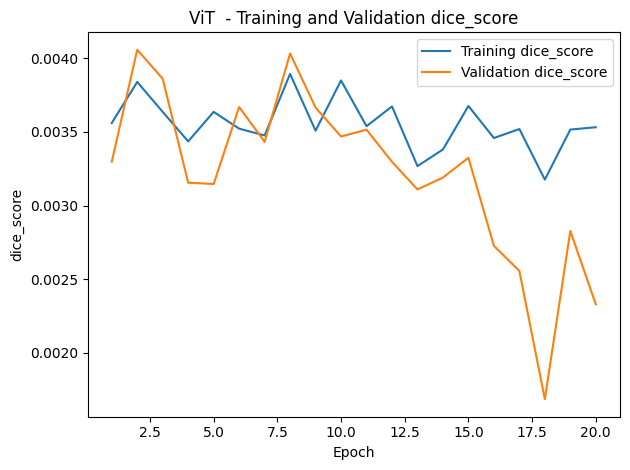

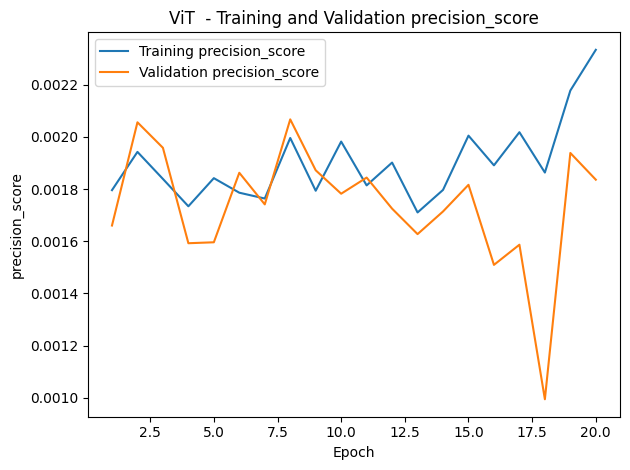

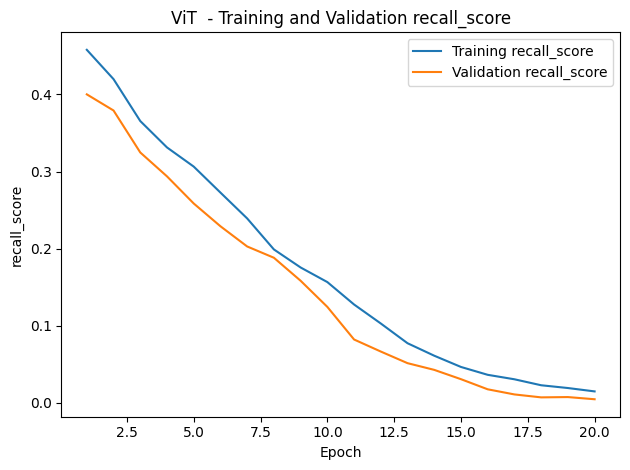

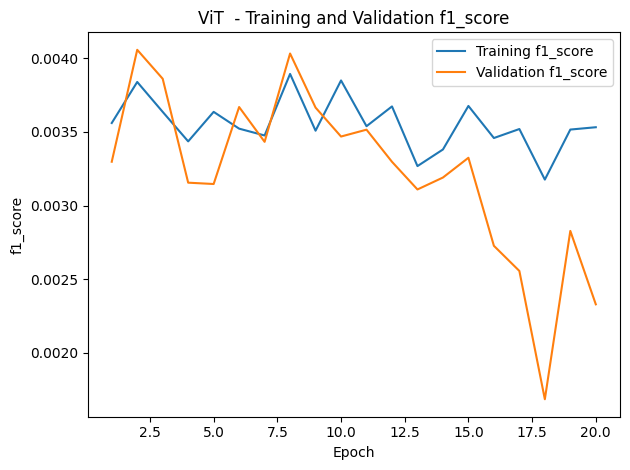

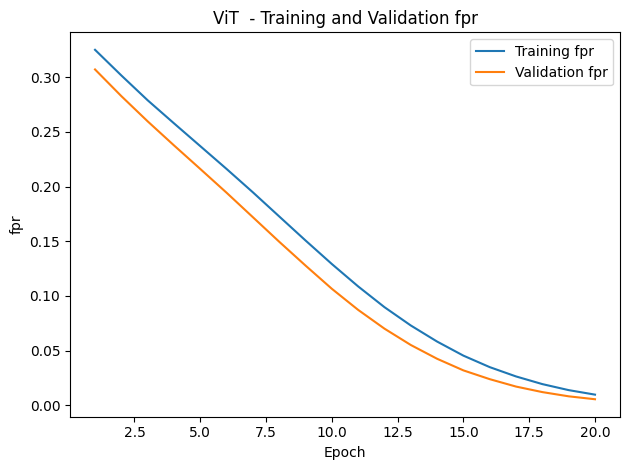

In [30]:
vit_metrics = ['dice_score', 'precision_score', 'recall_score', 'f1_score', 'fpr']

for metric in vit_metrics:
    plot_metric_history(vit_fold_metrics, metric, 'ViT ')

### Loss History Visualization


In [31]:
def plot_loss_history(fold_metrics, title=None):
    avg_train = []
    avg_test = []

    for fold in range(len(fold_metrics)):
        train = []
        test = []
        
        for epoch in range(len(fold_metrics[fold]['training_history'])):
            th = np.array(fold_metrics[fold]['training_history'][epoch]).mean()
            train.append(th)
            vh = np.array(fold_metrics[fold]['validation_history'][epoch]).mean()
            test.append(vh)
            
        avg_train.append(np.array(train))
        avg_test.append(np.array(test))
    
    epochs = len(np.mean(avg_train, axis=0)) + 1
        
    sns.lineplot(x=range(1, epochs), y=np.mean(avg_train, axis=0), label='Training history')
    sns.lineplot(x=range(1, epochs), y=np.mean(avg_test, axis=0), label='Validation history')
        
    plt.title(f'{title} - Training and Validation history')
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    plt.legend()
    
    plt.tight_layout()  
    plt.show()

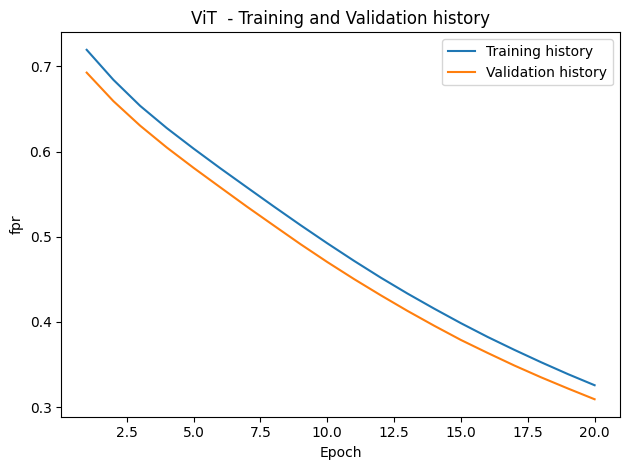

In [32]:
plot_loss_history(vit_fold_metrics, 'ViT ')

### Evaluate Test Set


#### ViT


In [33]:
df_vit_metrics = pd.DataFrame(columns=['fold', 'dice', 'precision', 'recall', 'f1', 'fpr'])
df_vit_metrics

,fold,dice,precision,recall,f1,fpr


In [34]:
df_vit_metrics['fold'] = [1, 2, 3, 4, 5]
df_vit_metrics['dice'] = vit_test_dice
df_vit_metrics['precision'] = vit_test_precision
df_vit_metrics['recall'] = vit_test_recall
df_vit_metrics['f1'] = vit_test_f1
df_vit_metrics['fpr'] = vit_test_fpr

In [35]:
vit_tk.dice = df_vit_metrics.dice
vit_tk.precision = df_vit_metrics.precision
vit_tk.recall = df_vit_metrics.recall
vit_tk.f1 = df_vit_metrics.f1
vit_tk.fpr = df_vit_metrics.fpr

In [36]:
df_vit_metrics

,fold,dice,precision,recall,f1,fpr
0,1,0.005398,0.003008,0.026316,0.005398,0.005325
1,2,0.000000,0.000000,0.000000,0.000000,0.004759
2,3,0.000000,0.000000,0.000000,0.000000,0.005040
3,4,0.002339,0.002392,0.002288,0.002339,0.004779
4,5,0.002997,0.002288,0.018219,0.002997,0.007227


In [37]:
# vit_iou_score = np.array(vit_test_iou).mean()
vit_dice_score = np.array(vit_test_dice).mean()
vit_precision_score = np.array(vit_test_precision).mean()
vit_recall_score = np.array(vit_test_recall).mean()
vit_f1_score = np.array(vit_test_f1).mean()
vit_fpr_score = np.array(vit_test_fpr).mean()

print('ViT Test Set Performance Metrics')
print(f'Average Dice Score: {vit_dice_score} ')
print(f'Average Precision: {vit_precision_score} ')
print(f'Average Recall: {vit_recall_score} ')
print(f'Average F1 Score: {vit_f1_score} ')
print(f'Average FPR: {vit_fpr_score} ')

ViT Test Set Performance Metrics
Average Dice Score: 0.002146883218918145 
Average Precision: 0.0015376385628101876 
Average Recall: 0.009364548494983277 
Average F1 Score: 0.002146883218918145 
Average FPR: 0.0054260181616123514 


In [38]:
df_vit_metrics.to_csv(f'{fold_dir}/vit_metrics.csv')

In [39]:
df_vit_metrics.to_csv(f'./statistical-treatment/perfect-bbox-vanilla-vit.csv')

### Sample


#### ViT


In [40]:
import matplotlib.patches as patches

C:\Users\araza\AppData\Local\Temp\ipykernel_30624\3482785095.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  f, a = plt.subplots(1, 2, figsize=(10, 4))


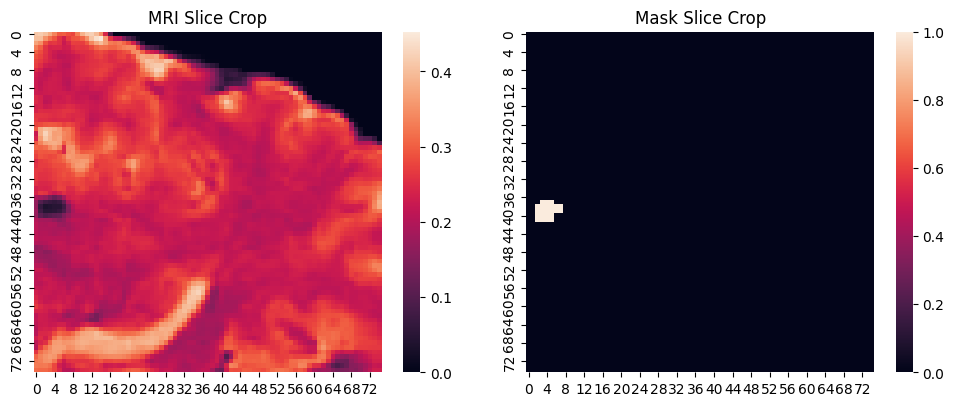

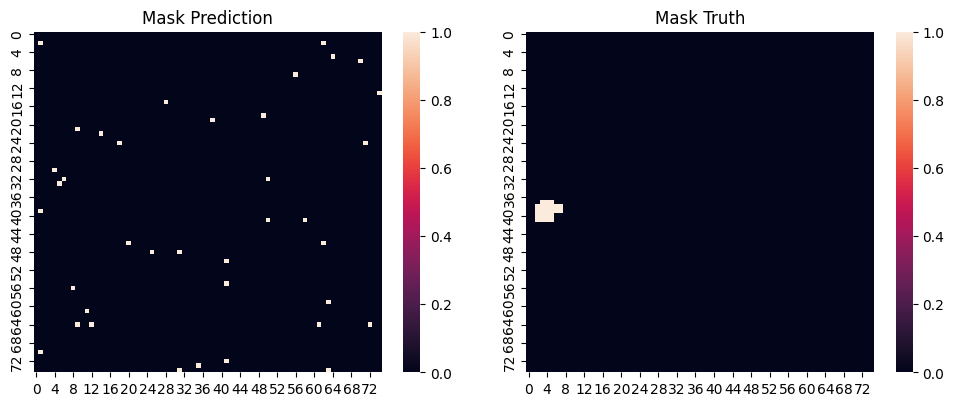

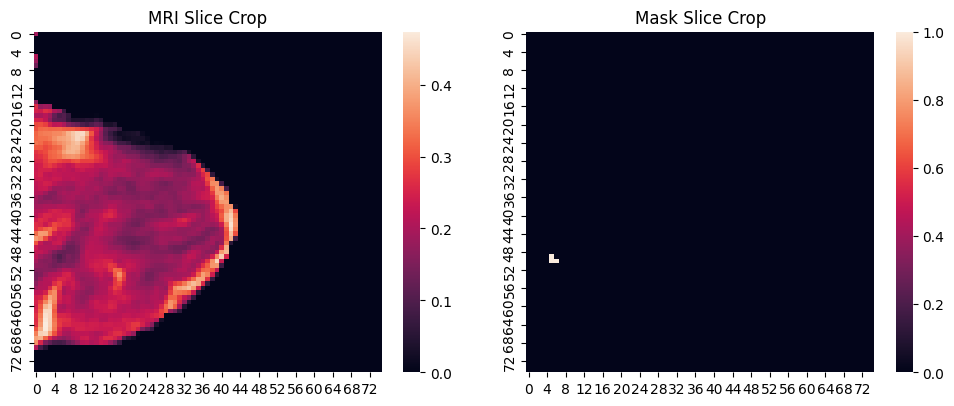

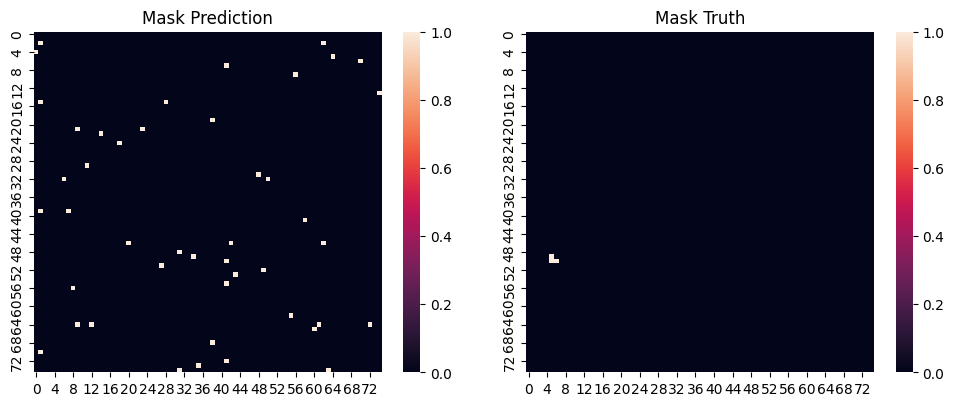

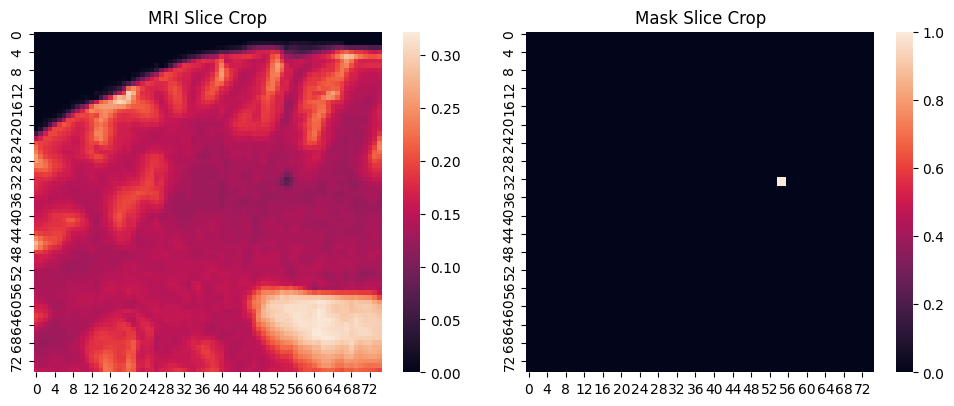

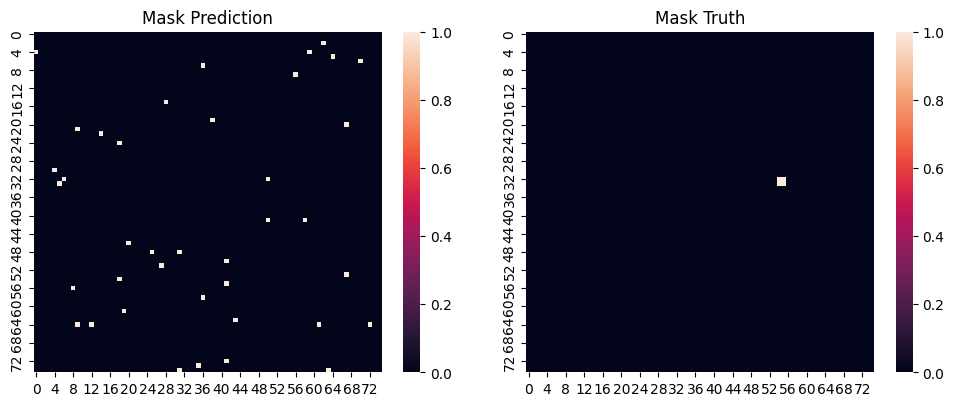

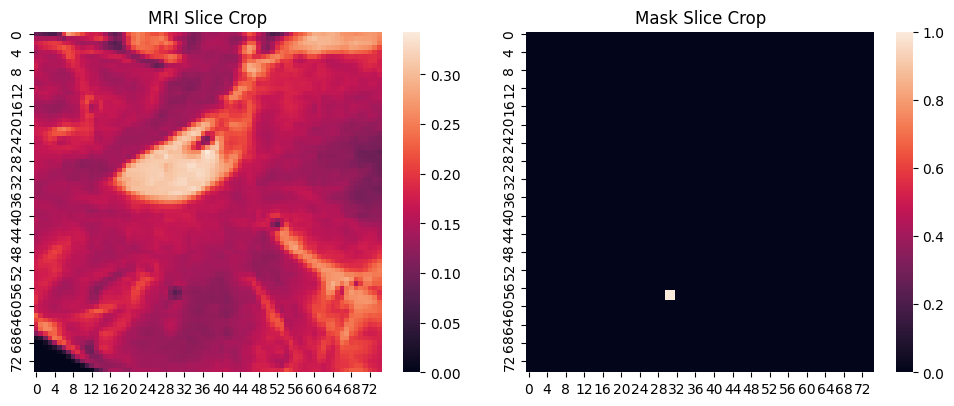

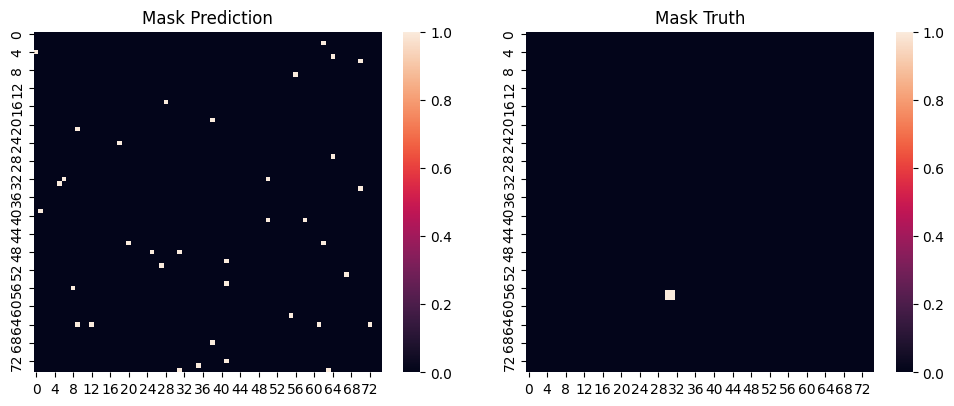

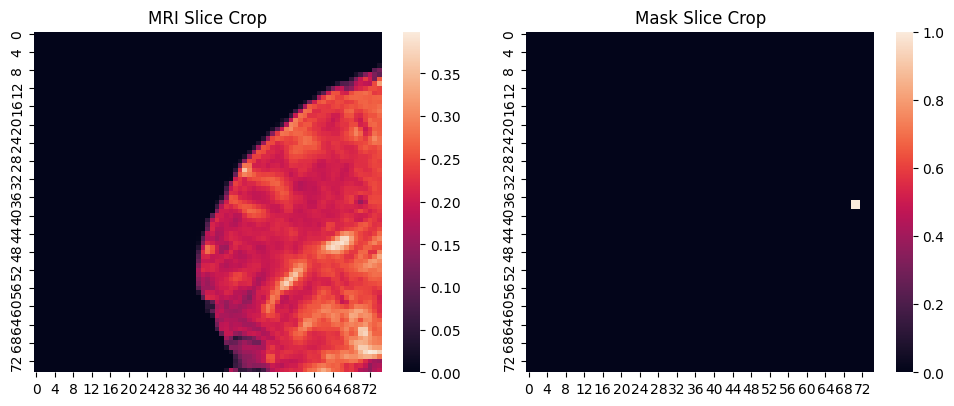

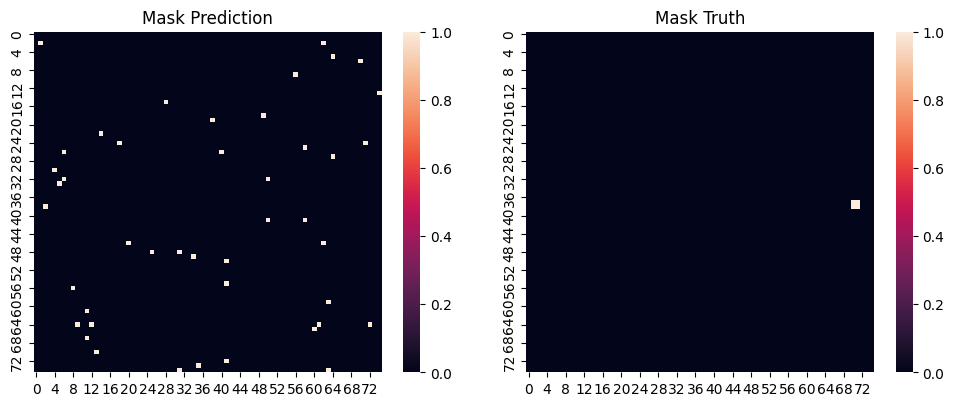

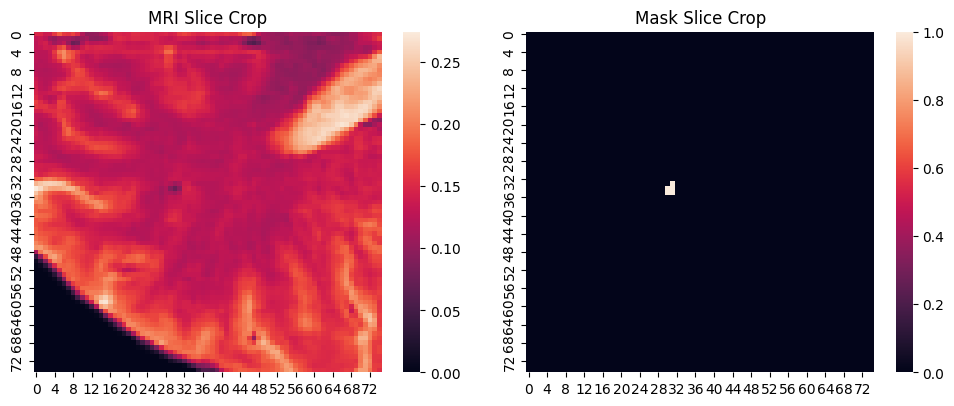

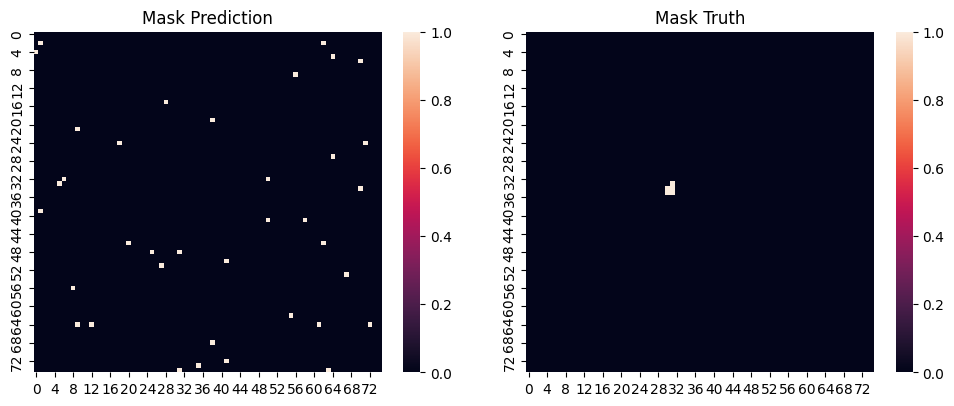

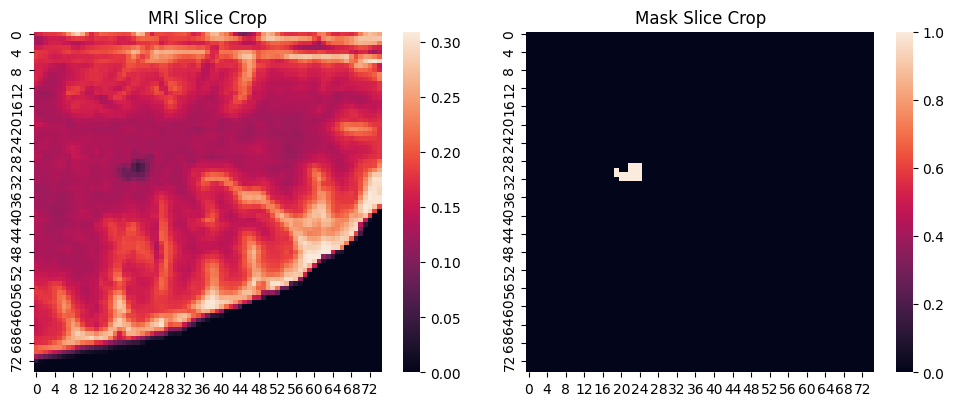

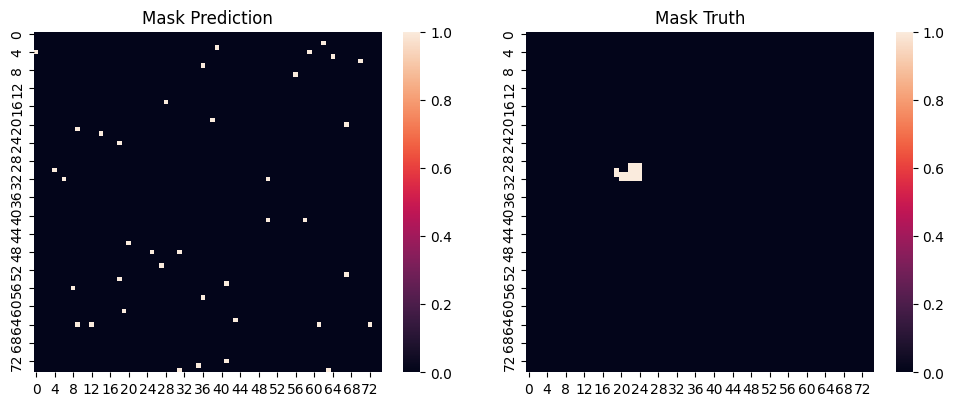

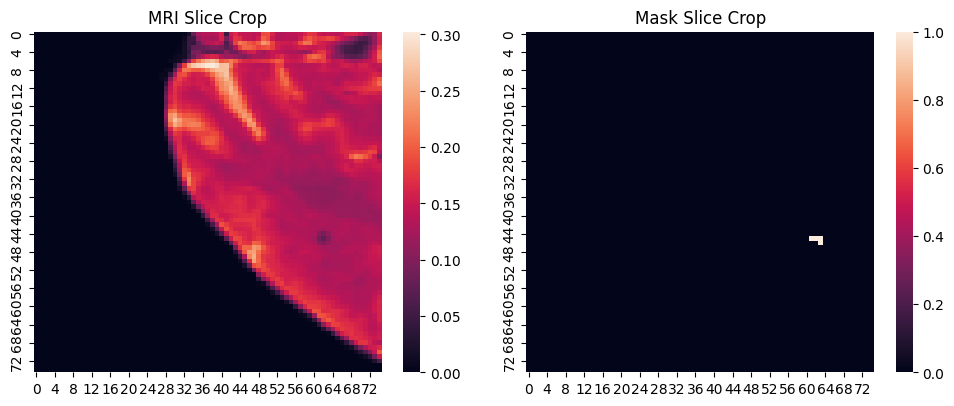

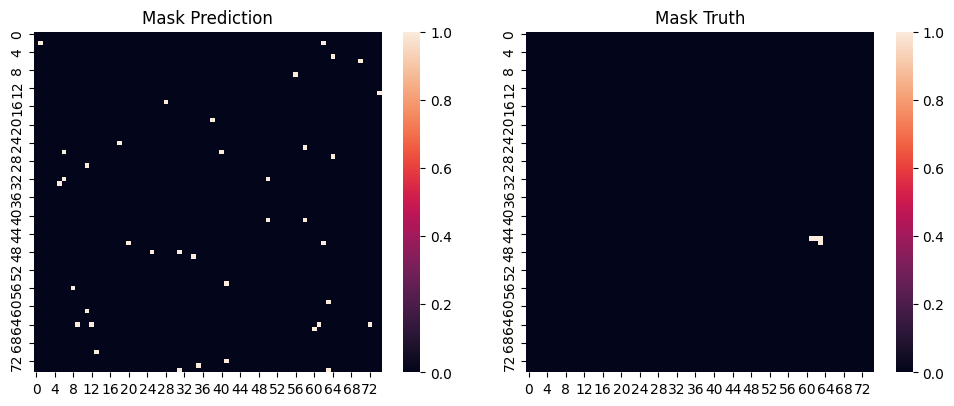

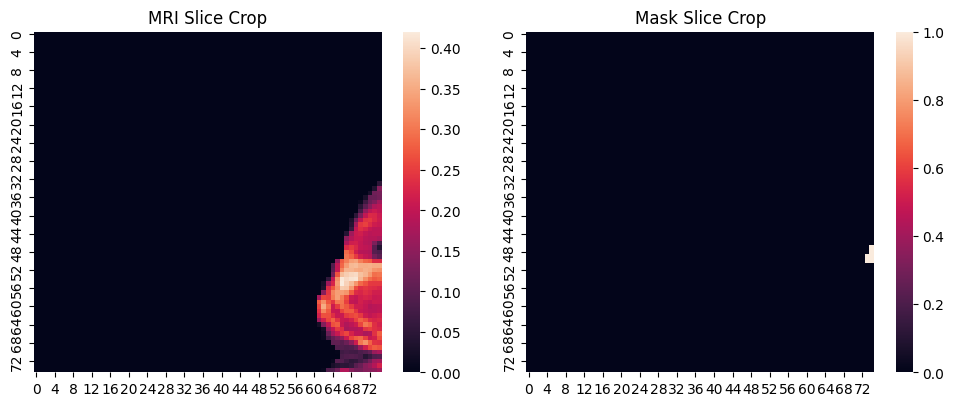

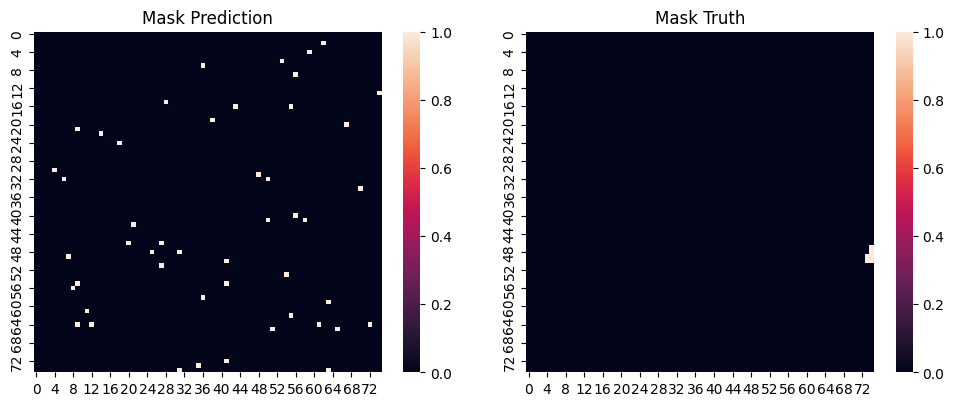

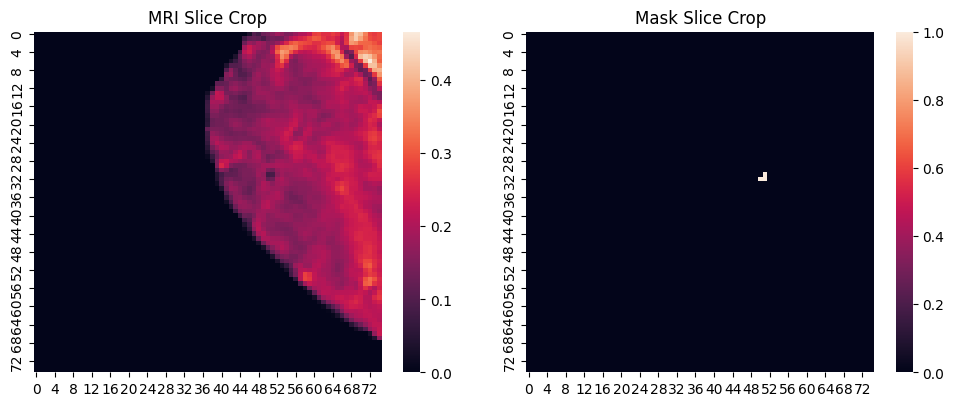

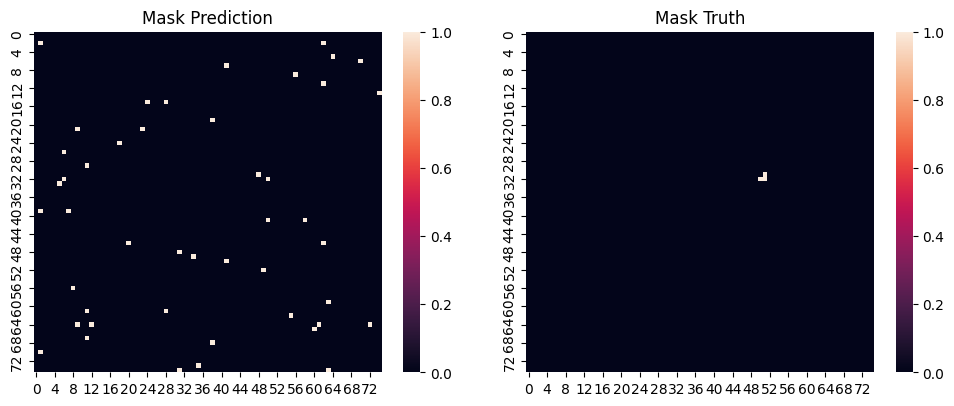

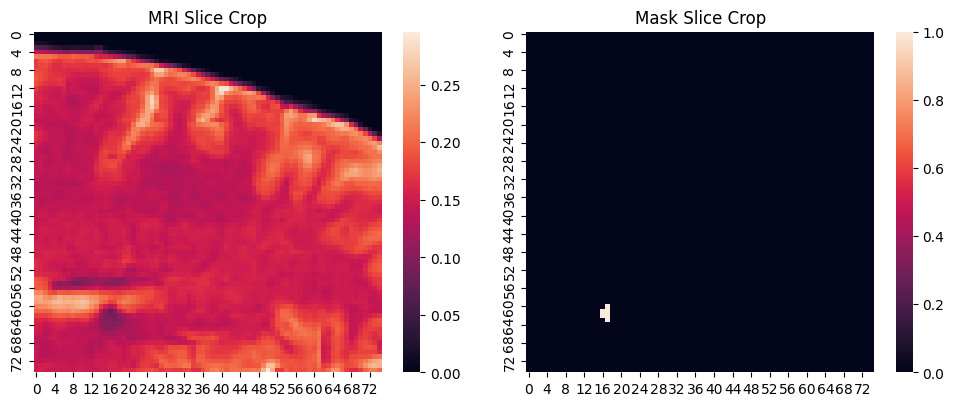

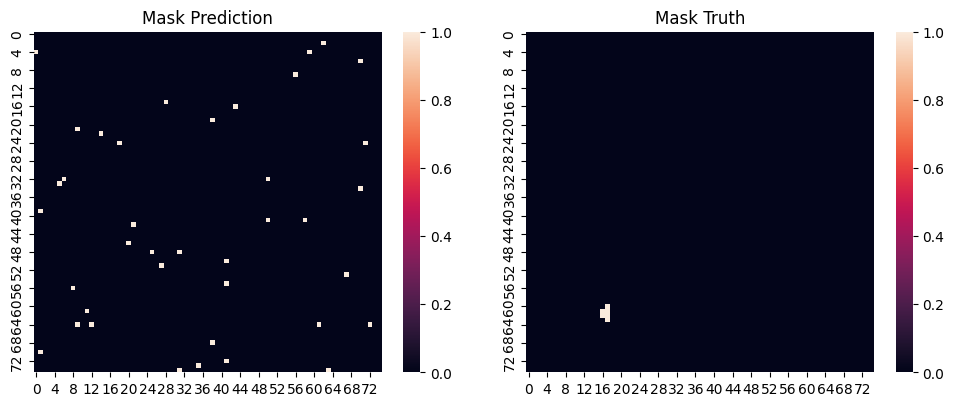

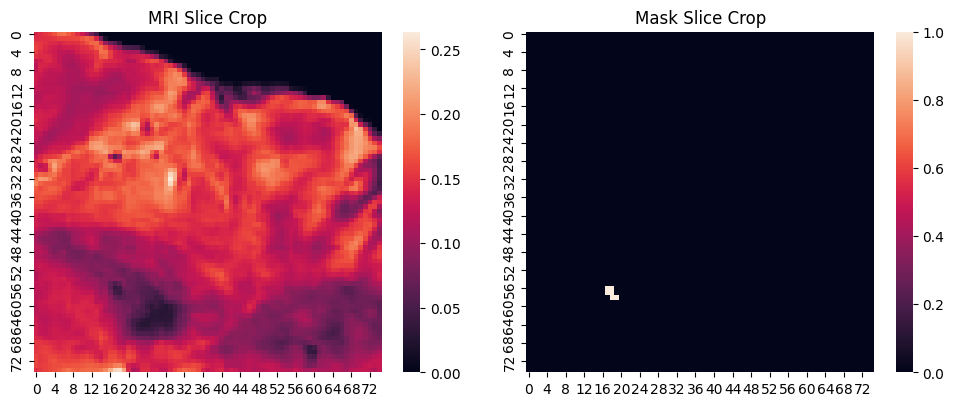

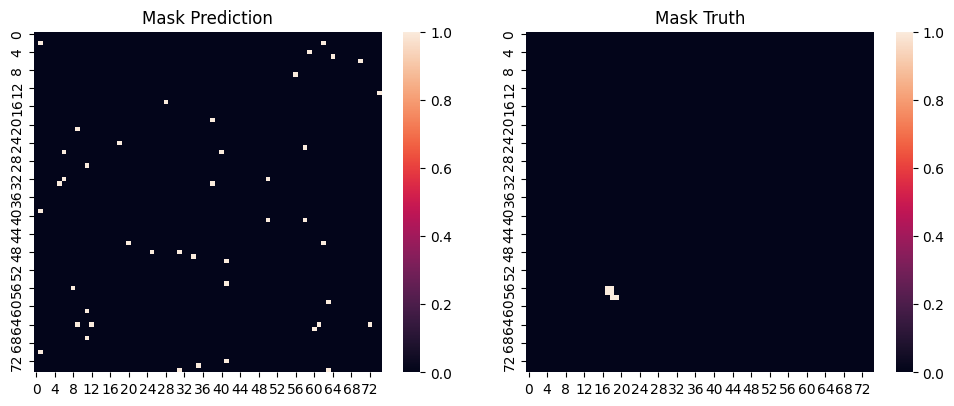

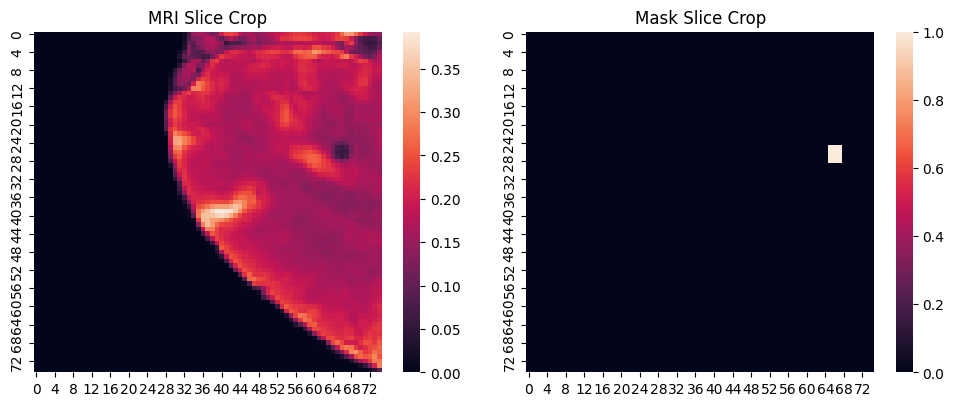

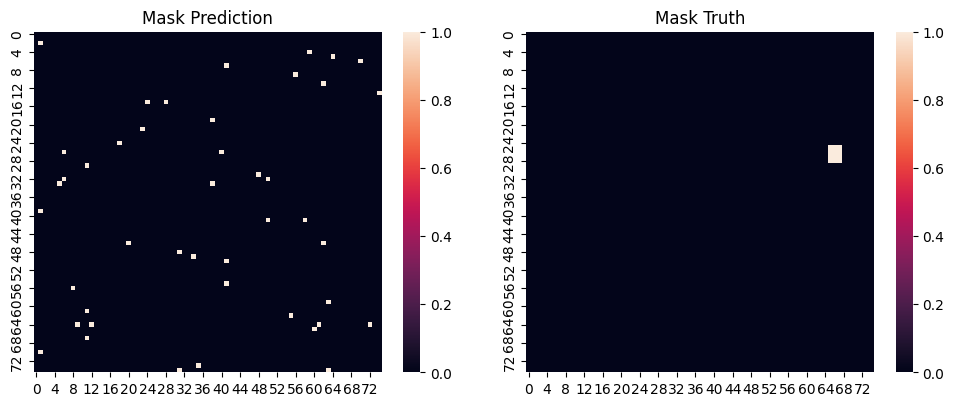

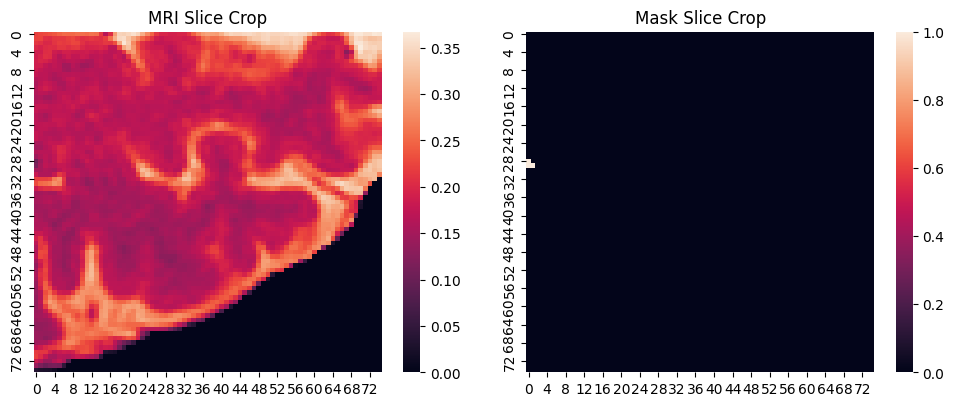

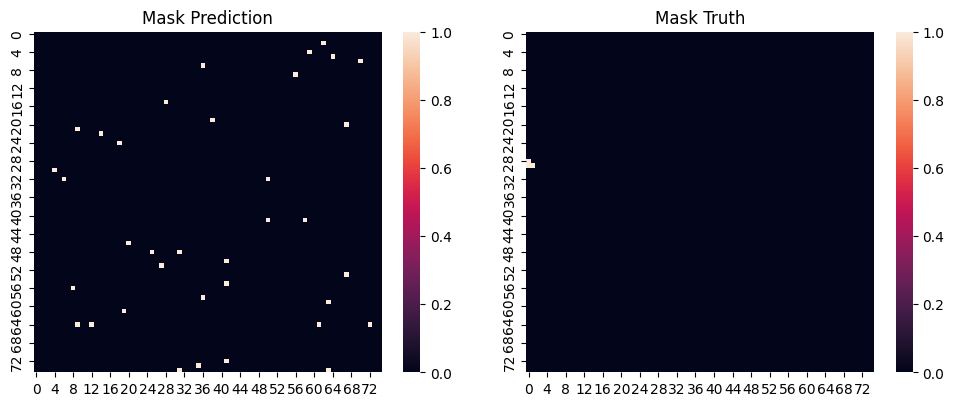

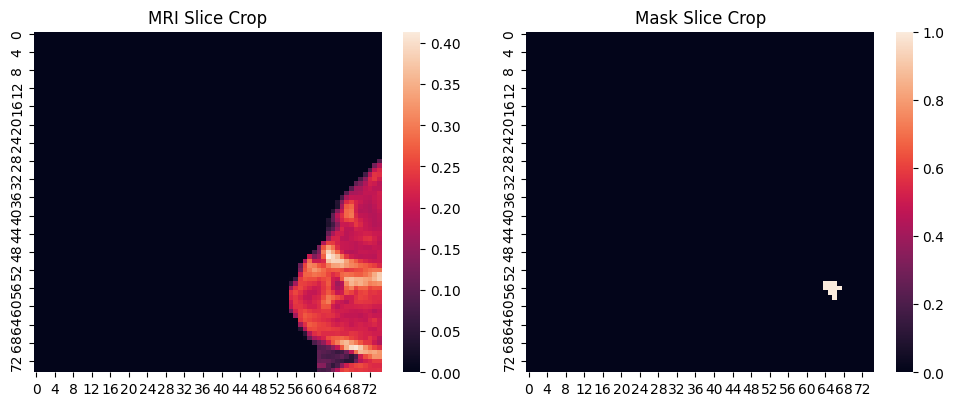

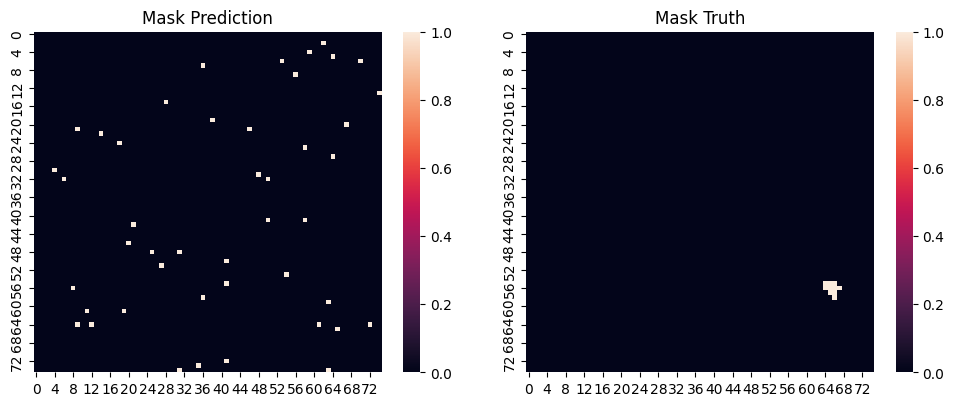

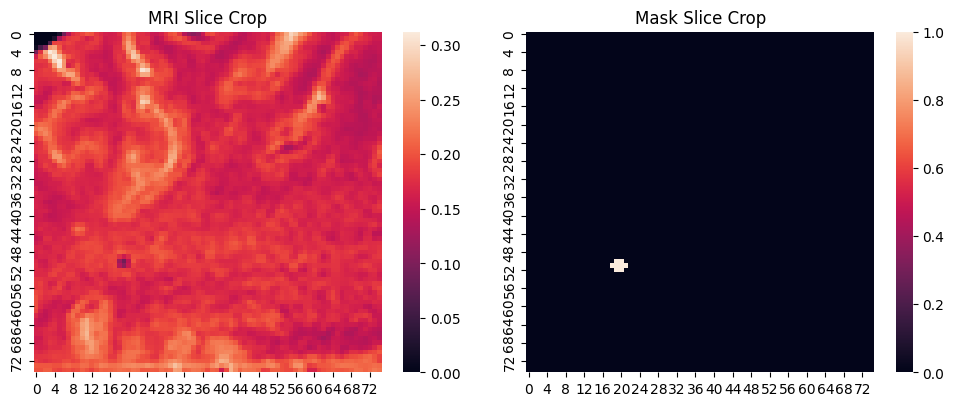

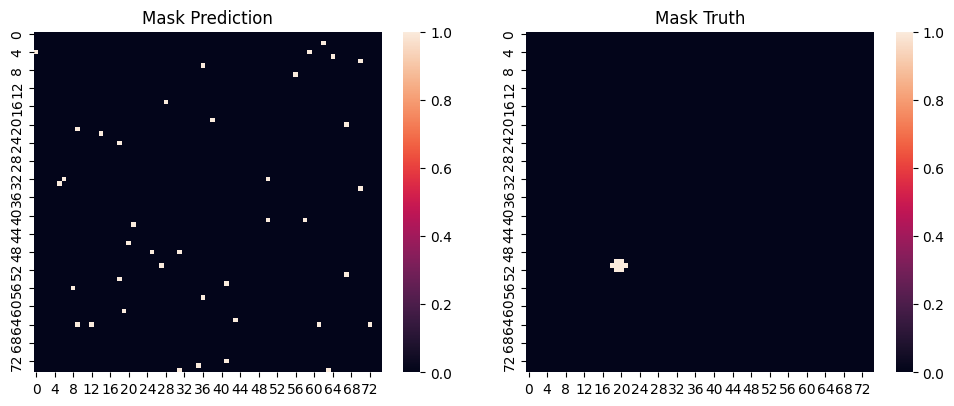

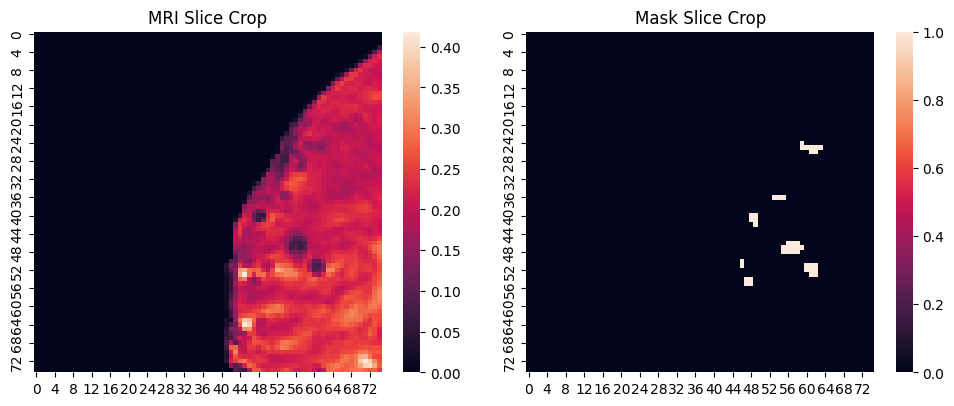

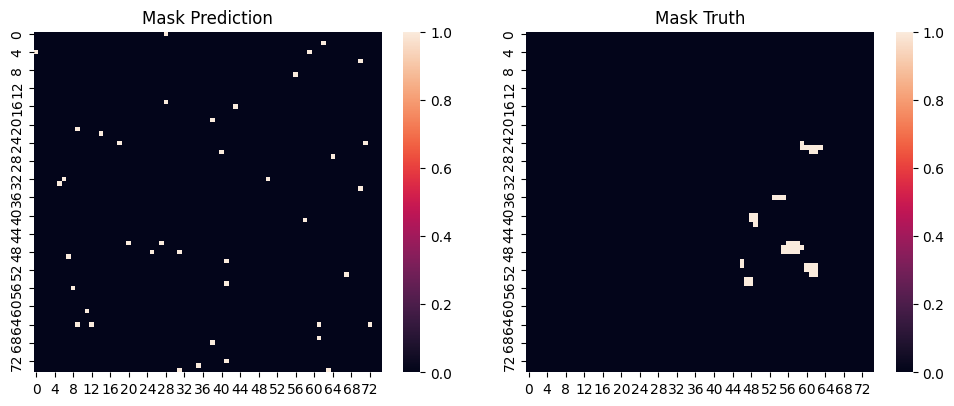

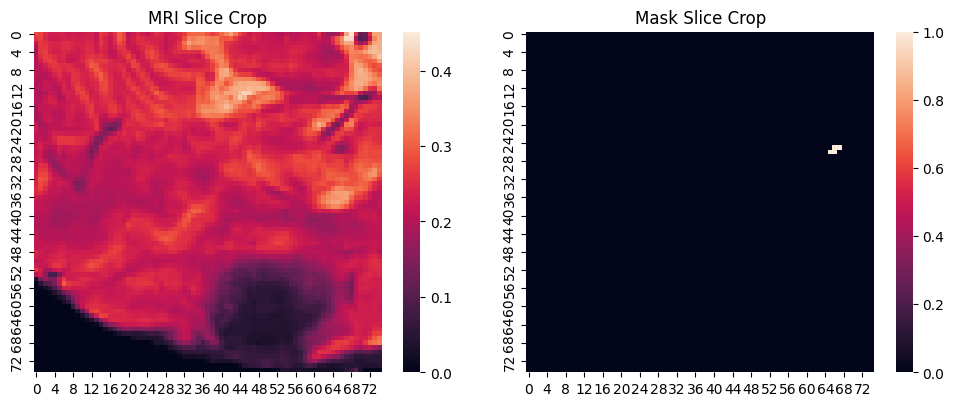

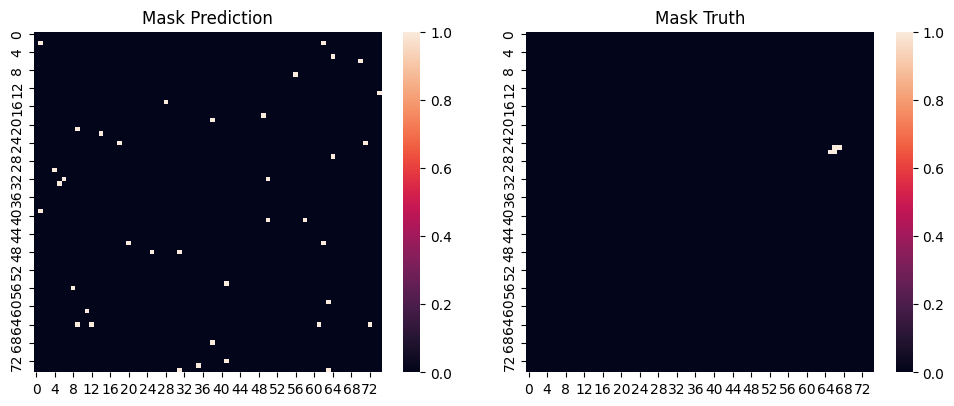

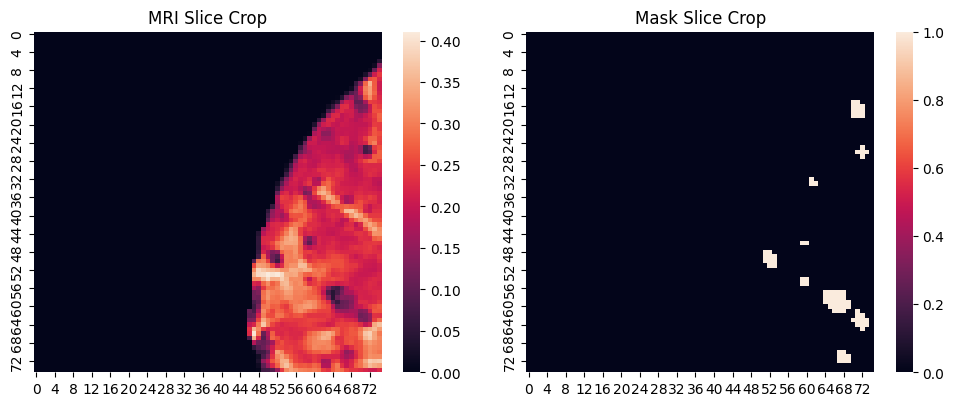

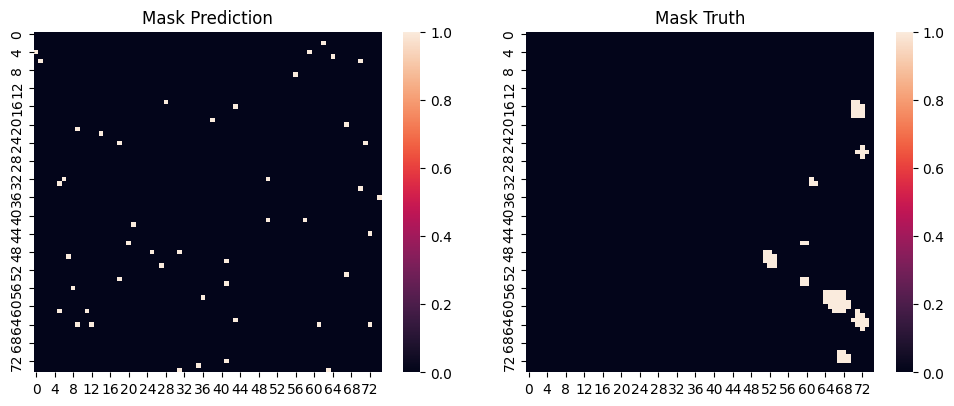

In [45]:
sample = next(iter(vit_test_dataloader))

for i in range(len(next(iter(vit_test_dataloader)))):
    vit_slices, vit_masks, vit_target, vit_case = sample[i]
    
    vit_slices = vit_slices.squeeze(1).float().to(device)
    vit_masks = vit_masks.float().to(device)
    
    # regions = feedset.locate_case_by_mri(vit_case)
    # bboxes = regions[1].view(regions[1].shape[0], -1)
    # bbox = bboxes[vit_target].int().tolist()
    gtruths = feedset.locate_case_by_mri(vit_case)[1]
    classes = gtruths[vit_target].squeeze().nonzero().squeeze()
    if classes.nelement() == 1:
        random_patch_with_cmb = classes.tolist()
    else:
        random_patch_with_cmb = classes[torch.randint(classes.nelement(), (1,))].squeeze().tolist()
    
                    
    # vit_x = feeder(vit_slices, bbox, 16)
    # vit_t = feeder(vit_masks, bbox, 16)
    cmri = []
    for i in range(vit_slices.shape[0]):
        slc = feeder(vit_slices[i].unsqueeze(0).float(), random_patch_with_cmb).unsqueeze(0)
        cmri.append(slc)
    vit_x = torch.stack(cmri)

    cmask = []
    for i in range(vit_masks.shape[0]):
        slc = feeder(vit_masks[i].unsqueeze(0).float(), random_patch_with_cmb).unsqueeze(0)
        cmask.append(slc)
    vit_t = torch.stack(cmask)

    
    f, a = plt.subplots(1, 2, figsize=(10, 4))

    f.tight_layout()
    ax1 = a.flat[0]
    ax2 = a.flat[1]
    ax1.set_title('MRI Slice Crop')
    ax2.set_title('Mask Slice Crop')
    sns.heatmap(vit_x[vit_target].squeeze().numpy(force=True), ax=ax1)
    sns.heatmap(vit_t[vit_target].squeeze().numpy(force=True), ax=ax2)

    vit_y = vit_fitter.model(vit_x.flatten(2).to(device), vit_target)
    vit_y = vit_y.view(patch_size, patch_size)
    
    f, a = plt.subplots(1, 2, figsize=(10, 4))

    f.tight_layout()
    ax1 = a.flat[0]
    ax2 = a.flat[1]
    ax1.set_title('Mask Prediction')
    ax2.set_title('Mask Truth')
    sns.heatmap((vit_y.sigmoid() >= 0.5).detach().cpu(), ax=ax1, vmax=1)
    sns.heatmap(vit_t[vit_target].squeeze().cpu(), ax=ax2, vmax=1)

In [46]:
while True:
    winsound.Beep(500, 1000)

KeyboardInterrupt: 

# Log Progress


In [ ]:
vit_tk.notes = '''
no global context
'''

In [ ]:
vit_tk()

In [ ]:
if os.path.exists('history/runs.csv'):
    print('Merging to old df')
    prev_df = pd.read_csv('history/runs.csv', index_col='date')
    merged = pd.concat([prev_df, vit_tk()])
    merged.to_csv('history/runs.csv')
else:
    print('Making new csv file')
    vit_tk().to_csv('history/runs.csv')